In [1]:
import numpy as np
from skimage.feature import corner_harris, peak_local_max
import json
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import skimage as sk
import scipy as sci
from scipy.interpolate import RegularGridInterpolator
import skimage.io as io
from scipy import ndimage
from matplotlib.path import Path
from PIL import Image, ImageDraw
from sklearn.neighbors import NearestNeighbors
import cv2
import os
import time
import datetime

### Camera Failure Detection


* Blank Frame Detection: 
  * Detects if the camera is returning blank or all-black frames, indicating no data is being captured.
* Frame Rate Monitoring: 
  * Identifies if the camera has stopped streaming frames or if there is a significant drop in frame rate.
* Overexposure or Underexposure Detection: 
  * Detects if the camera is consistently overexposed (too bright) or underexposed (too dark).
* Hardware connection check: 
  * Detects if the camera has been physically disconnected or has lost its connection to the system.

In [2]:
def is_blank_frame(frame, threshold=10):
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Calculate the average intensity
    avg_intensity = np.mean(gray_frame)
    return avg_intensity < threshold

def is_frame_rate_normal(current_time, threshold=0.5):
    global last_frame_time
    if last_frame_time is None:
        last_frame_time = current_time
        return True
    interval = current_time - last_frame_time
    last_frame_time = current_time
    return interval < threshold


def is_exposure_imbalanced(frame, dark_threshold=0.8, bright_threshold=0.8):
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Calculate histogram
    hist = cv2.calcHist([gray_frame], [0], None, [256], [0, 256])
    hist /= hist.sum()  # Normalize the histogram

    # Check for underexposure
    underexposed = hist[:10].sum() > dark_threshold
    # Check for overexposure
    overexposed = hist[245:].sum() > bright_threshold

    return underexposed or overexposed


def is_camera_connected(device="/dev/video0"):
    return os.path.exists(device)



In [3]:
def detect_camera_failures(cap, last_frame_time=None):
    """
    Detects camera failures and triggers appropriate actions.
    
    :param cap: OpenCV VideoCapture object for the camera
    :param last_frame_time: Timestamp of the last frame
    :return: Status dictionary of failure checks and updated last_frame_time
    """
    # Status dictionary to track failures
    failure_status = {
        "blank_frame": False,
        "frame_rate": True,  # Default true until first check
        "corrupted_frame": False,
        "exposure_imbalanced": False,
        "camera_connected": True
    }

    # Check hardware connection
    if not is_camera_connected():
        failure_status["camera_connected"] = False
        return failure_status, last_frame_time

    # Read frame
    ret, frame = cap.read()
    if not ret:
        failure_status["camera_connected"] = False
        return failure_status, last_frame_time

    # Check for blank frame
    if is_blank_frame(frame):
        failure_status["blank_frame"] = True

    # Check frame rate
    import time
    current_time = time.time()
    frame_rate_ok, last_frame_time = is_frame_rate_normal(current_time, last_frame_time)
    failure_status["frame_rate"] = frame_rate_ok

    # Check for overexposure or underexposure
    if is_exposure_imbalanced(frame):
        failure_status["exposure_imbalanced"] = True

    return failure_status, last_frame_time

# Trigger actions based on failures
def handle_failures(failure_status):
    """
    Handle detected camera failures by triggering appropriate actions.
    
    :param failure_status: Dictionary containing failure states
    """
    current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    if not failure_status["camera_connected"]:
        print(f"[{current_time}] Action: Reconnect the camera.")
    if failure_status["blank_frame"]:
        print(f"[{current_time}] Action: Check camera lens for obstructions or lighting conditions.")
    if not failure_status["frame_rate"]:
        print(f"[{current_time}] Action: Verify USB connection or reduce processing load.")
    if failure_status["corrupted_frame"]:
        print(f"[{current_time}] Action: Restart the camera or check sensor health.")
    if failure_status["exposure_imbalanced"]:
        print(f"[{current_time}] Action: Adjust camera exposure settings.")

In [4]:
cap = cv2.VideoCapture(0)  # Open the camera
last_frame_time = None
failure_start_time = None

while True:
    # Detect failures
    failure_status, last_frame_time = detect_camera_failures(cap, last_frame_time)

    # Check if any failure persists
    if any(failure_status.values()):
        if failure_start_time is None:
            failure_start_time = time.time()  # Start tracking failure time
        else:
            failure_duration = time.time() - failure_start_time
            if failure_duration > 5:  # Stop condition: failure persists for 10 seconds
                print("Cannot fix itself, deploying another TurtleBot to rescue.")
                break
    else:
        failure_start_time = None  # Reset failure timer if no issues detected

    # Handle failures
    handle_failures(failure_status)

    # Exit condition (press 'q' to quit)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 02:36:21] Action: Reconnect the camera.
[2024-12-13 

### Supporting functions

In [5]:
def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method="eps", sigma=1)
    coords = peak_local_max(h, min_distance=1)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (
        (coords[:, 0] > edge)
        & (coords[:, 0] < im.shape[0] - edge)
        & (coords[:, 1] > edge)
        & (coords[:, 1] < im.shape[1] - edge)
    )
    coords = coords[mask].T
    return h, coords

def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """

    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    # assert (dimx == dimc, "Data dimension does not match dimension of centers")

    return (
        (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T
        + np.ones((ndata, 1)) * np.sum((c**2).T, axis=0)
        - 2 * np.inner(x, c)
    )

def anms(coords, threshold, h):
    r = np.empty((coords.shape[1]))
    for i in range(0, coords.shape[1]):
        currH = h[coords[0, i], coords[1, i]]

        # start = timer()
        filteredY = coords[0][currH < threshold * h[coords[0], coords[1]]]
        filteredX = coords[1][currH < threshold * h[coords[0], coords[1]]]
        filteredCoords = np.array([filteredY, filteredX])

        filteredCoords[0] = np.square((coords[0, i] - filteredCoords[0]))
        filteredCoords[1] = np.square((coords[1, i] - filteredCoords[1]))

        sqDistances = filteredCoords[0] + filteredCoords[1]

        r[i] = float("inf") if len(sqDistances) == 0 else np.min(sqDistances)
        # r[i] = 0 if len(sqDistances) == 0 else np.min(sqDistances)
        # end = timer()
        # print(f"seq: {end-start}")
        # print(i)
        # print()

    return np.argsort(-r)

def findKeypoints(im, anmsThresh, numPoints):
    h, coords = get_harris_corners(im)
    # print(h.shape)
    # print(coords.shape)
    r = anms(coords[:], anmsThresh, h)
    topr = r[:numPoints]
    topCoords = coords[:, topr]
    topCoords = topCoords.swapaxes(0, 1)
    return topCoords

def featureDescriptors(im, coords, descriptorWidth, downSampleRatio, flatten=False):
    # Dont have to worry about edge coords bc of the harrison corner function

    descriptor = np.empty((coords.shape[0], descriptorWidth, descriptorWidth))
    reducedImg = sk.transform.downscale_local_mean(im, downSampleRatio)
    reducedCoords = np.floor_divide(coords, downSampleRatio)
    # print(reducedImg.shape)

    # print(reducedCoords)
    for i in range(coords.shape[0]):
        y, x = reducedCoords[i, 0], reducedCoords[i, 1]
        # print(f"[{y - (descriptorWidth // 2)} : {y + (descriptorWidth - (descriptorWidth // 2))},{x - (descriptorWidth // 2)} : {x + (descriptorWidth - (descriptorWidth // 2))}]")
        # print(y - (descriptorWidth // 2))
        # print(y + (descriptorWidth - (descriptorWidth // 2)))
        # print(x - (descriptorWidth // 2))
        # print(x + (descriptorWidth - (descriptorWidth // 2)))
        descriptor[i] = reducedImg[
            y - (descriptorWidth // 2) : y + (descriptorWidth - (descriptorWidth // 2)),
            x - (descriptorWidth // 2) : x + (descriptorWidth - (descriptorWidth // 2)),
        ]

        descriptor[i] = (descriptor[i] - np.mean(descriptor[i])) / np.std(descriptor[i])

    if flatten:
        descriptor = np.reshape(
            descriptor, (descriptor.shape[0], descriptor.shape[1] ** 2)
        )
    return descriptor
def rigid_transform_3D(A, B):
    # Input: expects 3xN matrix of points
    # Returns R,t
    # R = 3x3 rotation matrix
    # t = 3x1 column vector
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    # if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2, :] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

def calcH(im1Pt, im2Pt):
    """
    Finds the H transformation matrix using least squares for im1 and im2 points.

    Args:
        im1Pt (Nx3 np.array): im1 correspondances
        im2Pt (Nx3 np.array): im2 correspondances

    Returns:
        h (3x3 np.array): Linear solution of the transformation matrix
    """
    R, t = rigid_transform_3D(im1Pt.T, im2Pt.T)

    h = np.identity(4)

    h[0:3, 0:3] = R
    h[0:3, 3] = t.flatten()

    return h


def transformPoints(points, H):
    """
    Divides out W term in transformed points

    Args:
        points (Nx3 np.array): x,y,z coordinates of points
        H (4x4 np.array): Transformation Matrix

    Returns:
        result (Nx3 np.array): Original points transformed by H
    """
    ones = np.ones((points.shape[0], 1))
    homogPoints = np.append(points, ones, 1)
    transformedPoints = np.array([H @ p for p in homogPoints])
    return transformedPoints[:, 0:3]

def ransac(im1Coords, im2Coords, iterations, percentage, inlierTolerance=0.1):
    # Stops when either iterations are met, or if a percentage of the coords are in the inlier set
    largestInlier = []
    bestH = None
    rng = np.random.default_rng(12345)
    for i in range(iterations):
        rints = rng.integers(low=0, high=len(im1Coords) - 1, size=4)
        # print(rints)
        # print(im1Coords[rints], im2Coords[rints])
        H = calcH(im1Coords[rints], im2Coords[rints])
        guessCoords = transformPoints(im1Coords, H)
        distances = np.linalg.norm(guessCoords - im2Coords, axis=1)
        # print(distances.shape)
        # print(distances)
        inlier = np.argwhere(distances < inlierTolerance)
        if inlier.shape[0] > len(largestInlier):
            largestInlier = list(inlier[:, 0])
            print(
                f"{i}: {len(largestInlier)}, ({len(largestInlier)/im1Coords.shape[0]*100}%)"
            )
            if len(largestInlier) / im1Coords.shape[0] >= percentage:
                im1RANSACPts = im1Coords[largestInlier, :]
                im2RANSACPts = im2Coords[largestInlier, :]
                bestH = calcH(im1RANSACPts, im2RANSACPts)
                return largestInlier, bestH

    im1RANSACPts = im1Coords[largestInlier, :]
    im2RANSACPts = im2Coords[largestInlier, :]
    bestH = calcH(im1RANSACPts, im2RANSACPts)
    
    return largestInlier, bestH
import numpy as np

def calculate_transformation_matrix(points1, points2):
    """
    Calculate the rigid transformation matrix (R, T) that aligns points1 to points2.
    Uses the Umeyama algorithm.
    
    Parameters:
    points1: np.array of shape (N, 3) - Source points
    points2: np.array of shape (N, 3) - Target points
    
    Returns:
    transformation_matrix: np.array of shape (4, 4) - Homogeneous transformation matrix
    """
    assert points1.shape == points2.shape, "Both point sets must have the same shape."

    # Compute centroids
    centroid1 = np.mean(points1, axis=0)
    centroid2 = np.mean(points2, axis=0)

    # Center the points
    centered_points1 = points1 - centroid1
    centered_points2 = points2 - centroid2

    # Compute covariance matrix
    H = centered_points1.T @ centered_points2

    # Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Ensure a right-handed coordinate system (det(R) = 1)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # Compute translation
    T = centroid2 - R @ centroid1

    # Create a 4x4 transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = R
    transformation_matrix[:3, 3] = T

    return transformation_matrix

### Map 2D to 3D from matched feature

In [6]:
im1 = ndimage.rotate(io.imread("../../Assets/inside/inside1_Color.png"), 0)
im2 = ndimage.rotate(io.imread("../../Assets/inside/inside2_Color.png"), 0)
with open("../../Assets/inside/inside1_Color_inside2_Color.json") as jsonFile:
    keyPoints = json.load(jsonFile)
keyPointsIm1 = np.flip(np.array(keyPoints["im1Points"]),1)
keyPointsIm2 = np.flip(np.array(keyPoints["im2Points"]),1)

In [7]:
def showMatchedPoints(im1, im2, keyPointsIm1, keyPointsIm2):
    combinedIm = np.vstack([im1, im2])
    shiftedKeypointsIm2 = keyPointsIm2.copy()
    shiftedKeypointsIm2[:, 0] = shiftedKeypointsIm2[:, 0] + im1.shape[0]
    plt.imshow(combinedIm)
    plt.axis("off")
    point = 12
    plt.plot(
        # np.vstack([keyPointsIm1[point, 1], shiftedKeypointsIm2[point, 1]]),
        # np.vstack([keyPointsIm1[point, 0], shiftedKeypointsIm2[point, 0]]),
        np.vstack([keyPointsIm1[:, 1], shiftedKeypointsIm2[:, 1]]),
        np.vstack([keyPointsIm1[:, 0], shiftedKeypointsIm2[:, 0]]),
        "-o",
    )
    plt.savefig("../../Assets/resultsPt2/keypoints0_75Lowes.jpg", bbox_inches="tight", dpi=1000)

----- Filter points -----
(10, 2) (10, 2)

----- Run the camera, save the stream intrinsic parameters -----

----- Read images -----
RGB image shape: (720, 1280, 3)
Depth image shape: (720, 1280)
RGB image shape: (720, 1280, 3)
Depth image shape: (720, 1280)

----- Map 2D to 3D -----
Valid matched points of img_1 are 10, invalid ones are 0
Valid matched points of img_2 are 10, invalid ones are 0
(10, 3)

----- Determine transformation matrix to move -----
[[ 0.85323088  0.05106166 -0.51902772  0.89098598]
 [-0.11384621  0.98943053 -0.08981243  0.35511998]
 [ 0.5089559   0.13572008  0.85002586  0.53596936]
 [ 0.          0.          0.          1.        ]]

----- Show matched points -----


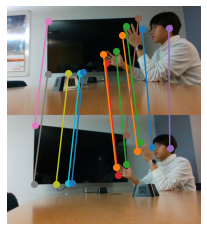

In [8]:
#TODO: Change pixle points to homogenous points in 3D space
from convertPixelTo3D import map2DTo3D, main, readInstantImage, loadCameraConfig
from getCameraConfig import saveCameraConfig

print("----- Filter points -----")
keyPointsIm1Filtered = np.concatenate(([keyPointsIm1[2]], keyPointsIm1[4:]), axis=0)
keyPointsIm2Filtered = np.concatenate(([keyPointsIm2[2]], keyPointsIm2[4:]), axis=0)
print(keyPointsIm1Filtered.shape, keyPointsIm2Filtered.shape)

depth_img_resolution = (1280, 720)

print("\n----- Run the camera, save the stream intrinsic parameters -----")
# saveCameraConfig(depth_stream_width=640, depth_stream_height=480)
intrinsic_matrix = loadCameraConfig()

print("\n----- Read images -----")
depth_img_path_1 = '../../Assets/inside/inside1_Depth.raw'
rgb_img_path_1 = '../../Assets/inside/inside1_Color.png'
rgb_img_1, depth_img_1 = readInstantImage(rgb_img_path_1, depth_img_path_1, depth_img_width=1280, depth_img_height=720, display=False)

depth_img_path_2 = '../../Assets/inside/inside2_Depth.raw'
rgb_img_path_2 = '../../Assets/inside/inside2_Color.png'
rgb_img_2, depth_img_2 = readInstantImage(rgb_img_path_2, depth_img_path_2, depth_img_width=1280, depth_img_height=720, display=False)



print("\n----- Map 2D to 3D -----")
homogenous_point_img_1, zero_coord_number_1 = map2DTo3D(rgb_img_1, depth_img_1, keyPointsIm1Filtered, intrinsic_matrix)
homogenous_point_img_2, zero_coord_number_2 = map2DTo3D(rgb_img_2, depth_img_2, keyPointsIm2Filtered, intrinsic_matrix)
print(f'Valid matched points of img_1 are {len(homogenous_point_img_1)}, invalid ones are {zero_coord_number_1}')
print(f'Valid matched points of img_2 are {len(homogenous_point_img_2)}, invalid ones are {zero_coord_number_2}')
print(homogenous_point_img_1.shape)


print("\n----- Determine transformation matrix to move -----")
transformation_matrix = calculate_transformation_matrix(homogenous_point_img_1, homogenous_point_img_2)
print(transformation_matrix)

print("\n----- Show matched points -----")
showMatchedPoints(im1, im2, keyPointsIm1, keyPointsIm2)
